In [1]:
# import os
import matplotlib.pyplot as plt
import os
import pandas as pd
from amftrack.util.sys import get_analysis_folders,get_time_plate_info_from_analysis,get_time_hypha_info_from_analysis,get_global_hypha_info_from_analysis, get_time_plate_info_long_from_analysis
import numpy as np
import imageio
import os
import cv2
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from amftrack.pipeline.final_analysis.density_wave import get_wave_fit, S, dS, wave, dwave
import matplotlib.patches as mpatches
from random import choice
import matplotlib as mpl
from amftrack.pipeline.final_analysis.density_wave import plot_single_plate,plot_single_plate_biovolume
from amftrack.pipeline.final_analysis.hypha_speed_analysis import *
from amftrack.util.plot import gridplot, make_stat
%store -r path_figure
%matplotlib widget
%load_ext autoreload
%autoreload 2
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import scipy
import statsmodels.api as sm
import hashlib
from matplotlib.patches import Ellipse
import logging
from helper import *
from load_dataframes import load_all

plt.style.use('presentation.mplstyle')
logging.getLogger().setLevel(logging.WARNING)

all_analysis_folders = get_analysis_folders()
#for P
plates = [
"416_20230705",
"427_20230707",
"420_20230705",
"431_20230627",
"474_20230807",
"460_20230807",
"464_20230807",
"440_20230723",
"436_20230717",
"443_20230720",
"439_20230804",
"470_20230709",
'478_20230814', '468_20230809', '447_20230821', '487_20230922',
       '492_20230901', '471_20230821', '486_20231009',
       '494_20230908', '482_20230908', '495_20231013', '463_20231013',
       '491_20231013', '481_20231005', '483_20231005',
    '490_20231003',
       '485_20230929',
]
analysis_folders = all_analysis_folders.loc[all_analysis_folders['unique_id'].isin(plates)]
path_figure = r"C:\Users\coren\Documents\PhD\paper\PandC\Fig3"


c:\users\coren\documents\phd\code\amftrack\amftrack\util\dbx.py:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
Vmax_schnepf = 3.26e-6 #umol/cm**2/s-1
Vmax_schnepf *= 31 #ug/cm**2/s-1
Vmax_schnepf *= 1e-2 #ug/mm**2/s-1
Vmax_schnepf *= 3600 #ug/mm**2/h-1
Vmax_schnepf

0.0036381599999999997

In [3]:
# folders,time_plate_info = get_time_plate_info_from_analysis(analysis_folders,False)
folders,time_plate_info = get_time_plate_info_long_from_analysis(analysis_folders,False)
time_plate_info['unique_id'] = time_plate_info['unique_id'].replace(47020230709,47020230802)
time_plate_info=time_plate_info[time_plate_info['Plate']!=431]
# time_plate_info['time_since_begin_hour'] = time_plate_info['time_since_begin_h'].dt.total_seconds() / 3600.0
# time_plate_info['time_since_begin_hour'] = time_plate_info['time_since_begin_h']

In [4]:
import pandas as pd

# Assuming df is your DataFrame
columns_to_check = [f'SA_region_{i}' for i in range(18)] + [f'length_density_region_{i}' for i in range(18)]

# Filter DataFrame rows where any of the specified columns have NaN values
df_filtered = time_plate_info[time_plate_info[columns_to_check].isna().any(axis=1)]

# Find the unique ids corresponding to those rows
unique_ids_with_nans = df_filtered['unique_id'].unique()

print("Unique IDs with at least one NaN in specified columns:", unique_ids_with_nans)


Unique IDs with at least one NaN in specified columns: [47420230807]


In [5]:
[plate for plate in plates if int(plate) not in time_plate_info['unique_id'].unique()]

['431_20230627',
 '470_20230709',
 '495_20231013',
 '463_20231013',
 '491_20231013']

In [6]:
def calculate_integral(df, column, new_column):
    # Calculate the time difference within each group
    df['time_since_begin_hour'] = df['time_since_begin_h'].dt.total_seconds() / 3600.0
    df['time_diff'] = df.groupby('unique_id')['time_since_begin_hour'].transform(lambda x: x.diff())

    # Calculate the average length density within each group
    df['avg_length_density'] = df.groupby('unique_id')[column].transform(lambda x: x.rolling(window=2).mean())

    # Calculate the "area" (using Trapezoidal rule) for each pair of rows within each group
    df['area'] = df['time_diff'] * df['avg_length_density']

    # Perform the integration (cumulative sum of "area") within each group
    df[new_column] = df.groupby('unique_id')['area'].transform(lambda x: x.cumsum())

    # Drop the helper columns if needed
    df.drop(['time_diff', 'avg_length_density', 'area'], axis=1, inplace=True)

In [7]:
for i in range(18):
    calculate_integral(time_plate_info,f'SA_region_{i}',f'integrated_SA_{i}')
for i in range(18):
    calculate_integral(time_plate_info,f'length_density_region_{i}',f'integrated_L_{i}')


In [8]:
coarse_to_basic_mapping = {
    1: [1, 2],
    2: [3, 8],
    3: [4, 5],
    4: [6, 7],
    5: [9, 10],
    6: [11, 12],
    7: [13],
    8: [14, 15],
    9: [16, 17, 18]
}

# Mapping for "simple" to "basic"
simple_to_basic_mapping = {
    0: list(range(1, 11)),
    1: list(range(11, 19))
}
sub_to_basic_mapping = {
    0: list(range(1, 19)),
}

In [9]:
import pandas as pd
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from helper import *
from amftrack.notebooks.P_experiment.helper import get_polygons
%load_ext autoreload
%autoreload 2
plt.style.use('presentation.mplstyle')

%matplotlib widget
C_max2 = 1.53

def fit_function(x, C_max):
    return 1+C_max * 1/x**(3/2)
# Read the Excel file
path = r'C:\Users\coren\Documents\PhD\Pexperiment'
path_excel = os.path.join(path,'summary.xlsx')
df = pd.read_excel(path_excel)
df['date_from_unique_id'] = pd.to_datetime(df['unique_id'].str.split('_').str[1], format='%Y%m%d')
    
# Convert 'day' column to datetime
df['day_sample'] = pd.to_datetime(df['day_sample'], format='%Y%m%d')  # Update the format as necessary
df['day_start'] = pd.to_datetime(df['start'], format='%Y%m%d')  # Update the format as necessary

df['time_elapsed'] = df['day_sample'] - df['day_start']
df['time_elapsed_day'] = df['time_elapsed'].dt.days
df['time_since_crossing'] = df['day_sample'] - df['date_from_unique_id']
df['t2 (day)'] = df['time_since_crossing'].dt.days
df['t1 (day)'] = df['time_elapsed_day']-df['t2 (day)']
df['treatment'] = df['treatment'].fillna('none')
df['wet_weight_measured'] = df['wet weight']

df['wet weight'] = df['wet weight']-df['lost weight']
df['totP (ug)'] = df['totP (ug)'] * fit_function(df['totP (ug)'], C_max2)
df['Sample_name'] = df['Sample_name'].str.replace('bottom','0')
df['Sample_name'] = df['Sample_name'].str.replace('up','1')
df['Sample_name'] = df['Sample_name'].str.replace('top','1')
df['Sample_name'] = df['Sample_name'].str.replace('agar','0')



df = df.loc[df['plate']!=487]
df = df.loc[df['type'] == 'agar']
df['pos'] = df['Sample_name'].str.split('-').str.get(1).astype(int)

time_plate_info.sort_values(['unique_id', 'time_since_begin_h'], inplace=True)

# Group by unique_id and take the last entry for each group
last_values = time_plate_info.groupby('unique_id').last().reset_index()

# Create a function to map 'pos' to the corresponding integrated_Ldens_i value
def get_integrated_density(row):
    unique_id = row['unique_id']
    pos = row['pos']
    arrangement = row['arrangement']
    if arrangement == 'basic':
        col_names = [f'integrated_SA_{pos-1}']
    if arrangement == 'simple':
        col_names = [f'integrated_SA_{basic_pos-1}' for basic_pos in simple_to_basic_mapping[pos]]
    if arrangement == 'coarse':
        col_names = [f'integrated_SA_{basic_pos-1}' for basic_pos in coarse_to_basic_mapping[pos]] 
    if arrangement == 'sub':
        col_names = [f'integrated_SA_{basic_pos-1}' for basic_pos in sub_to_basic_mapping[pos]] 
    if not unique_id is np.nan:
        last_value_row = last_values[last_values['unique_id'] == int(unique_id)]
        return np.sum(last_value_row[col_names].values) if not last_value_row.empty else None
    else:
        return(None)
df['integrated_SA'] = df.apply(get_integrated_density, axis=1)

grouped = df.groupby(['plate', 'type', "time_elapsed_day", "t1 (day)", "treatment", 't2 (day)', "arrangement","day_start"]).agg({
    'totP (ug)': 'sum',
    'wet weight': ['sum', 'median'],
    "wet_weight_measured":"sum",
    'dry weight': 'sum',
    'integrated_SA':"sum"
}).reset_index()

# Rename columns
grouped.columns = ['_'.join(col).strip() if col[0] == 'wet weight' else col[0] for col in grouped.columns]
grouped = grouped.rename(columns={
    'wet weight_sum': 'tot_wet_weight',
    'wet weight_median': 'wet_weight_median'
})
grouped['C_P'] = grouped['totP (ug)'] / grouped['tot_wet_weight']
grouped['P_content'] = grouped['totP (ug)'] / grouped['dry weight']/1e6

df['C_P'] = df['totP (ug)'] / df['wet weight']
df['P_content'] = df['totP (ug)'] / df['dry weight']/1e6
# df = df[df['type'] != 'sub']

grouped = grouped[grouped['plate']!=487]
grouped = grouped[grouped['plate']!=431]



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
df['integrated_SA_C']=df['integrated_SA']/df['wet weight']
# grouped = dfgrouped = df.groupby(['plate', 'type',"time_elapsed_day","t1 (day)","treatment",'t2 (day)']).agg({'totP (ug)': 'sum', 'wet weight': 'sum','dry weight' : "sum",'integrated_SA':"sum"}).reset_index()
grouped['C_P'] = grouped['totP (ug)'] / grouped['tot_wet_weight']
grouped['P_content'] = grouped['totP (ug)'] / grouped['dry weight']/1e6
grouped['integrated_SA_C']=grouped['integrated_SA']/grouped['tot_wet_weight']
tot_weights = grouped[grouped['type'].isin(["agartot", "rootagartot"])].set_index(['plate', 'type'])['wet_weight_measured'].to_dict()

# Function to determine the 'measured_tot_wet_weight' based on conditions
def get_tot_weight(row):
    if row['type'] == 'agar' and (row['plate'], 'agartot') in tot_weights:
        return tot_weights[(row['plate'], 'agartot')]
    elif row['type'] == 'rootagar' and (row['plate'], 'rootagartot') in tot_weights:
        return tot_weights[(row['plate'], 'rootagartot')]
    else:
        return row['wet_weight_measured']

# Apply the function to get 'measured_tot_wet_weight' column
grouped['measured_tot_wet_weight'] = grouped.apply(get_tot_weight, axis=1)
grouped= grouped[grouped['type'] != 'rootagartot']
grouped= grouped[grouped['type'] != 'agartot']
# Step 1: Identify plates that don't have any rows with type "agartot"
plates_with_agartot = grouped[grouped['type'] == 'rootagartot']['plate'].unique()
valid_plates = grouped[~grouped['plate'].isin(plates_with_agartot)]

# Step 2: Compute the average "wet weight" for type 'agar' and 'rootagar'
average_wet_weight_agar = valid_plates[valid_plates['type'] == 'agar']['measured_tot_wet_weight'].mean()
average_wet_weight_rootagar = valid_plates[valid_plates['type'] == 'rootagar']['measured_tot_wet_weight'].mean()

# Step 3: Replace rows in the 'average weight' column accordingly
grouped['average weight'] = None  # Initialize column with None values
grouped.loc[grouped['type'] == 'agar', 'average weight'] = average_wet_weight_agar
grouped.loc[grouped['type'] == 'rootagar', 'average weight'] = average_wet_weight_rootagar
grouped.loc[grouped['type'] == 'agar', 'fullP'] = grouped.loc[grouped['type'] == 'agar', 'measured_tot_wet_weight'] *grouped.loc[grouped['type'] == 'agar', 'C_P']
grouped.loc[grouped['type'] == 'rootagar', 'fullP'] = grouped.loc[grouped['type'] == 'rootagar', 'measured_tot_wet_weight'] *grouped.loc[grouped['type'] == 'rootagar', 'C_P']
grouped.loc[grouped['type'] == 'root', 'fullP'] = grouped.loc[grouped['type'] == 'root', 'totP (ug)']
totP_theory = 100
grouped['scaling_factor'] = totP_theory/grouped.groupby('plate')['fullP'].transform('sum')

# Multiply 'fullP' by the scaling factor to get 'fullP_rescaled'
grouped['fullP_rescaled'] = grouped['fullP'] * grouped['scaling_factor']

In [11]:
grouped_agar = grouped.copy()

2024-01-25 19:51:57,544-[WARNING]- fontTools.subset:2983 -> meta NOT subset; don't know how to subset; dropped


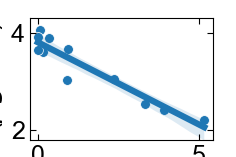

In [12]:
cm = 1/2.54  # centimeters in inches

fig,ax = plt.subplots(figsize = (6*cm,4*cm))
select = grouped_agar[grouped_agar['t2 (day)']<=9]
select = select[select['treatment']=='100P']



# sns.scatterplot(df,x = 'integrated_SA_C',y = 'C_P',ax = ax,hue ="treatment",s = 6)
sns.scatterplot(select,x = 'integrated_SA_C',y = 'C_P',ax = ax,s=50)
sns.regplot(select,x = 'integrated_SA_C',y = 'C_P',ax = ax,scatter = False)

# ax.set_xscale('log')
ax.set_ylim(1.8,4.3)
plt.ylabel('[P] \n ($\mu g/mL$)')
plt.xlabel('$\int_0^{t_f} SA(t)dt$ \n ($\mu m^2h/mL$)')
plt.savefig(os.path.join(path_figure,'Figure3A.pdf'), transparent=True, bbox_inches='tight')


In [13]:
slope, intercept, r_value, p_value, std_err = stats.linregress(select['integrated_SA_C'], select['C_P'])
slope2, intercept, r_value, p_value, std_err = stats.linregress(select['integrated_SA'], select['fullP'])

In [14]:
slope2,slope

(-3.2554048752748486e-09, -3.3973588349543932e-09)

In [15]:
std_err*1e6*24*365

2.9715786346588478

In [16]:
gegeé

NameError: name 'gegeé' is not defined

In [24]:
df = pd.read_excel(path_excel)
df['date_from_unique_id'] = pd.to_datetime(df['unique_id'].str.split('_').str[1], format='%Y%m%d')
    
# Convert 'day' column to datetime
df['day_sample'] = pd.to_datetime(df['day_sample'], format='%Y%m%d')  # Update the format as necessary
df['day_start'] = pd.to_datetime(df['start'], format='%Y%m%d')  # Update the format as necessary

df['time_elapsed'] = df['day_sample'] - df['day_start']
df['time_elapsed_day'] = df['time_elapsed'].dt.days
df['time_since_crossing'] = df['day_sample'] - df['date_from_unique_id']
df['t2 (day)'] = df['time_since_crossing'].dt.days
df['t1 (day)'] = df['time_elapsed_day']-df['t2 (day)']
df['treatment'] = df['treatment'].fillna('none')
df['wet_weight_measured'] = df['wet weight']

df['wet weight'] = df['wet weight']-df['lost weight']
df['totP (ug)'] = df['totP (ug)'] * fit_function(df['totP (ug)'], C_max2)

grouped = df.groupby(['plate', 'type', "time_elapsed_day", "t1 (day)", "treatment", 't2 (day)', "arrangement","day_start"]).agg({
    'totP (ug)': 'sum',
    'wet weight': ['sum', 'median'],
    "wet_weight_measured":"sum",
    'dry weight': 'sum'
}).reset_index()

# Rename columns
grouped.columns = ['_'.join(col).strip() if col[0] == 'wet weight' else col[0] for col in grouped.columns]
grouped = grouped.rename(columns={
    'wet weight_sum': 'tot_wet_weight',
    'wet weight_median': 'wet_weight_median'
})
grouped['C_P'] = grouped['totP (ug)'] / grouped['tot_wet_weight']
grouped['P_content'] = grouped['totP (ug)'] / grouped['dry weight']/1e6

df['C_P'] = df['totP (ug)'] / df['wet weight']
df['P_content'] = df['totP (ug)'] / df['dry weight']/1e6
tot_weights = grouped[grouped['type'].isin(["agartot", "rootagartot"])].set_index(['plate', 'type'])['wet_weight_measured'].to_dict()

# Function to determine the 'measured_tot_wet_weight' based on conditions
def get_tot_weight(row):
    if row['type'] == 'agar' and (row['plate'], 'agartot') in tot_weights:
        return tot_weights[(row['plate'], 'agartot')]
    elif row['type'] == 'rootagar' and (row['plate'], 'rootagartot') in tot_weights:
        return tot_weights[(row['plate'], 'rootagartot')]
    else:
        return row['wet_weight_measured']

# Apply the function to get 'measured_tot_wet_weight' column
grouped['measured_tot_wet_weight'] = grouped.apply(get_tot_weight, axis=1)
# Step 1: Identify plates that don't have any rows with type "agartot"
plates_with_agartot = grouped[grouped['type'] == 'rootagartot']['plate'].unique()
valid_plates = grouped[~grouped['plate'].isin(plates_with_agartot)]

# Step 2: Compute the average "wet weight" for type 'agar' and 'rootagar'
average_wet_weight_agar = valid_plates[valid_plates['type'] == 'agar']['measured_tot_wet_weight'].mean()
average_wet_weight_rootagar = valid_plates[valid_plates['type'] == 'rootagar']['measured_tot_wet_weight'].mean()

# Step 3: Replace rows in the 'average weight' column accordingly
grouped['average weight'] = None  # Initialize column with None values
grouped.loc[grouped['type'] == 'agar', 'average weight'] = average_wet_weight_agar
grouped.loc[grouped['type'] == 'rootagar', 'average weight'] = average_wet_weight_rootagar
grouped.loc[grouped['type'] == 'agar', 'fullP'] = grouped.loc[grouped['type'] == 'agar', 'measured_tot_wet_weight'] *grouped.loc[grouped['type'] == 'agar', 'C_P']
grouped.loc[grouped['type'] == 'rootagar', 'fullP'] = grouped.loc[grouped['type'] == 'rootagar', 'measured_tot_wet_weight'] *grouped.loc[grouped['type'] == 'rootagar', 'C_P']
grouped.loc[grouped['type'] == 'root', 'fullP'] = grouped.loc[grouped['type'] == 'root', 'totP (ug)']
totP_theory = 100
grouped['scaling_factor'] = totP_theory/grouped.groupby('plate')['fullP'].transform('sum')

# Multiply 'fullP' by the scaling factor to get 'fullP_rescaled'
grouped['fullP_rescaled'] = grouped['fullP'] * grouped['scaling_factor']
grouped = grouped.merge(grouped_agar[['plate','integrated_SA_C','integrated_SA']],how = "left",on='plate')

In [25]:
100/28

3.5714285714285716

2024-01-25 19:55:47,409-[WARNING]- fontTools.subset:2983 -> meta NOT subset; don't know how to subset; dropped


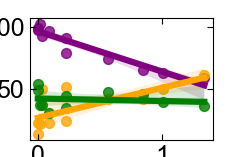

In [30]:
from matplotlib.lines import Line2D
select= grouped[grouped['fullP']>0]
select= select[select['treatment']=='100P']
select = select[select['t2 (day)']<=9]
select = select[select['plate']!=431]
select = select[select['plate']!=487]
column = 'integrated_SA'
t2_values = select[column].unique()
color_dict = {
    'root': 'blue',
    'agar': 'red',
    'rootagar': 'green'
}
# Plotting
fig,ax = plt.subplots(figsize = (6*cm,4*cm))
# Unique categories in the hue column
types = select['type'].unique()
color_dict = {
    'root': 'orange',
    'agar': 'purple',
    'rootagar': 'green'
}

# Iterate over each category
for type_obj in types:
    # Subset data for the category
    subset = select[select['type'] == type_obj]

    # Create a regplot for the subset
    sns.regplot(x=subset[column], y=subset['fullP'], color = color_dict[type_obj],scatter_kws= {"s":50})

# for t2 in sorted(t2_values):
#     plate_data = select[select[column] == t2]
#     for k,type_ in enumerate(['root', 'agar', 'rootagar']):
#         value = plate_data[plate_data['type'] == type_]['fullP'].mean()
#             # print(t2,plate_data[plate_data['type'] == type_]['plate'])
#         ax.scatter(t2, value, color=color_dict[type_])
#         # print(t2,value,plate_data)

ax.set_ylabel('fullP Value')
ax.set_xlabel('t2 Value')


ax.set_ylabel('P mass (ug)')
ax.set_xlabel('Time since crossing (day)')
plt.ylabel('$m_P$ \n ($\mu g$)')
plt.xlabel('$\int_0^{t_f} SA(t)dt$ \n ($\mu m^2h$)')
plt.savefig(os.path.join(path_figure,'Figure3B.pdf'), transparent=True, bbox_inches='tight')

In [31]:
subset = select[select['type'] == 'agar']

slope2, intercept, r_value, p_value, std_err = stats.linregress(subset['integrated_SA'], subset['fullP'])
slope2

-3.2554048752748486e-09

In [18]:
from plates import plates,timestep

df2,final_data = load_all(plates)

C:\Users\coren\Documents\PhD\Code\pycode\P_depletion_paper\final_figures\load_dataframes.py:111: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df_sum['start'] = pd.to_datetime(df_sum['start'], errors='coerce')
C:\Users\coren\Documents\PhD\Code\pycode\P_depletion_paper\final_figures\load_dataframes.py:112: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df_sum['crossed']  = pd.to_datetime(df_sum['crossed'], errors='coerce')
C:\Users\coren\Documents\PhD\Code\pycode\P_depletion_paper\final_figures\load_dataframes.py:113: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsi

In [32]:
def calculate_derivative(df, column, new_column, window=1):
    # Ensure the DataFrame is sorted by 'unique_id' and 'time_since_begin_h'
    df.sort_values(by=['unique_id', 'time_since_begin_h'], inplace=True)
    
    # Calculate the time difference and value difference over the desired window
    df['time_diff'] = df.groupby('unique_id')['time_since_begin_h'].transform(lambda x: x.diff(window)).fillna(0)
    df['value_diff'] = df.groupby('unique_id')[column].transform(lambda x: x.diff(window)).fillna(0)

    # Calculate the derivative (value difference divided by time difference)
    # Be cautious about dividing by zero. If 'time_diff' is 0, set derivative to NaN or handle accordingly.
    df[new_column] = df.apply(lambda x: x['value_diff'] / x['time_diff'] if x['time_diff'] != 0 else None, axis=1)

    # Drop the helper columns
    df.drop(['time_diff', 'value_diff'], axis=1, inplace=True)
def calculate_integral(df, column, new_column):
    # Calculate the time difference within each group
    df.sort_values(by=['unique_id', 'time_since_begin_h'], inplace=True)
    df['time_since_begin_hour'] = df['time_since_begin_h']
    df['time_diff'] = df.groupby('unique_id')['time_since_begin_hour'].transform(lambda x: x.diff())

    # Calculate the average length density within each group
    df['avg_length_density'] = df.groupby('unique_id')[column].transform(lambda x: x.rolling(window=2).mean())

    # Calculate the "area" (using Trapezoidal rule) for each pair of rows within each group
    df['area'] = df['time_diff'] * df['avg_length_density']

    # Perform the integration (cumulative sum of "area") within each group
    df[new_column] = df.groupby('unique_id')['area'].transform(lambda x: x.cumsum())

    # Drop the helper columns if needed
    df.drop(['time_diff', 'avg_length_density', 'area'], axis=1, inplace=True)

In [33]:
Vmax = 3.8e-9 #ugP/um2/hour
density = 1e-6 #ug/um3
dry_wet_ratio = 0.3
carbon_ratio = 0.5
carbon_ratio_spore = 0.9
dry_wet_ratio_spore = 0.9
density_spore = 0.9e-6
respiration_ratio = 0.5

In [34]:
baseline = final_data[final_data['time_since_begin_h'] == 0]

# Step 2: Create a series with spore_volume at time_since_begin_h = 0 for each unique_id
baseline_volume = baseline.groupby('unique_id')['spore_volume'].first()
final_data['adjusted_spore_volume'] = final_data.groupby('unique_id')['spore_volume'].transform(lambda x: x - baseline_volume[x.name])

final_data['totC_hypha'] = final_data['tot_biovolume_study']*density*dry_wet_ratio*carbon_ratio
final_data['tot_volume'] = final_data['adjusted_spore_volume']+final_data['tot_biovolume_study']
final_data['totC_spore'] = final_data['adjusted_spore_volume']*density_spore*dry_wet_ratio_spore*carbon_ratio_spore
final_data['totC_tot'] = final_data['totC_hypha'] + final_data['totC_spore']
calculate_integral(final_data,f'tot_surface_area_study',f'integrated_SA')

In [38]:
final_data['absorbed_P'] = final_data['integrated_SA']*Vmax
final_data['P_C_ratio'] = final_data['absorbed_P']/final_data['totC_tot']*100
final_data = final_data.reset_index(drop=True)


2024-01-25 20:03:52,529-[WARNING]- fontTools.subset:2983 -> meta NOT subset; don't know how to subset; dropped


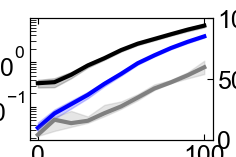

In [40]:
fig,ax = plt.subplots(figsize = (6*cm,4*cm))
ax2 = ax.twinx()
select = final_data
select = final_data[final_data['real_root']=="Carrot Toby"]
# select = select[select['time_since_begin_h_shifted'] < select['time_since_begin_h_shifted_max_c_rate']+20]
select = select[select['time_hour_binned'] <= 50]
select = select[select['time_hour_binned'] > -55]
select = select[select['fungalC']=='100P/100N/100C']

select = select[select['strain'] == "C2"]
select = select.copy()
select['time_reshift'] = select['time_hour_binned']+50



grouped = select.groupby('time_hour_binned')
filtered_groups = grouped.filter(lambda x: x['unique_id'].nunique() >= 7)

sns.lineplot(data=filtered_groups,x='time_reshift',y='absorbed_P',estimator = "mean",color="blue",ax = ax)
sns.lineplot(data=filtered_groups,x='time_reshift',y='totC_tot',estimator = "mean",color="black",ax=ax)
sns.lineplot(data=filtered_groups,x='time_reshift',y='P_C_ratio',estimator = "median",color="grey",ax = ax2)


ax.set_yscale("log")
# ax2.set_yscale("log")

# ax.set_xlim(-100,500)
ax2.set_ylim(0,100)

ax.set_ylabel('m ($\mu g$)')
ax2.set_ylabel('$m_P/m_C$ (%)')

ax.set_xlabel('t-t* (hour)')

# ax.set_ylabel('C expenditure rate ($\mu g/h$)')
# ax.set_xlabel('P acquisition rate ($\mu g/h$)')
plt.savefig(os.path.join(path_figure,'Figure3C.pdf'), transparent=True, bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots()
sns.scatterplot(data=filtered_groups,x='time_since_begin_h',y='integrated_SA')
ax.scatter(select1['t2 (day)']*24,select1['integrated_SA'])

In [ ]:
select = final_data
select = final_data[final_data['real_root']=="Carrot Toby"]
# select = select[select['time_since_begin_h_shifted'] < select['time_since_begin_h_shifted_max_c_rate']+20]
select = select[select['time_hour_binned'] <= 50]
select = select[select['time_hour_binned'] > -55]
select = select[select['fungalC']=='100P/100N/100C']

select = select[select['strain'] == "C2"]
select = select.copy()
select['time_reshift'] = select['time_hour_binned']+50



grouped = select.groupby('time_hour_binned')
filtered_groups = grouped.filter(lambda x: x['unique_id'].nunique() >= 7)

In [ ]:
select1 = grouped_agar[grouped_agar['t2 (day)']<=9]
select1 = select1[select1['treatment']=='100P']